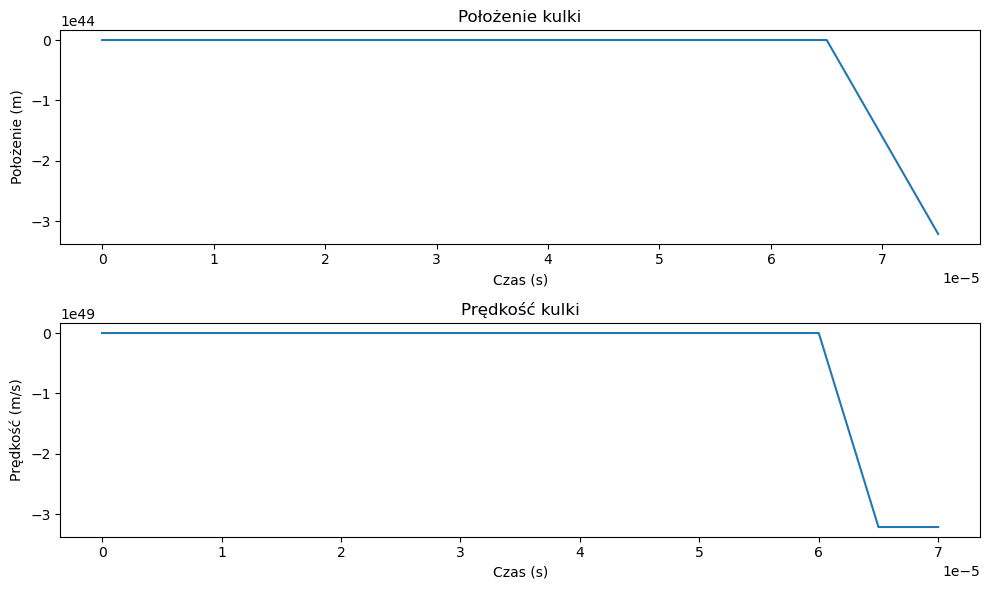

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numba

# Definicje stałych
frequency = 40000  # Hz
wavelength = 343 / frequency  # m
initial_amplitude = 400  # Zwiększona amplituda
rho_air = 1.225  # kg/m^3
c_air = 343  # m/s
mu_air = 1.82e-5  # Pa*s
radius = 0.01  # m
rho_particle = 30  # kg/m^3
c_particle = 900  # m/s
mass = (4/3) * np.pi * radius**3 * rho_particle  # kg
diameter = 2 * radius

# Współczynniki potencjału Gorkova
K1 = (1 / (4 * np.pi * c_air**2 * rho_air)) * (1 - (rho_air / rho_particle))
K2 = (1 / (8 * np.pi * c_air**2 * rho_air)) * ((rho_particle - rho_air) / (2 * rho_particle + rho_air))

# Parametry dodatkowych sił
q_particle = 1e-9  # Ładunek elektryczny kulki (Coulomb)
epsilon_0 = 8.854e-12  # Stała dielektryczna próżni (F/m)
A_vdw = 1e-20  # Stała Hamakera dla sił van der Waalsa (Joule)
T_gradient = 1e2  # Gradient temperatury (K/m)
alpha_thermal = 1e-3  # Stała termoforetyczna

# Dokładniejsze modelowanie pola akustycznego
@numba.njit
def acoustic_field_amplitude(z, transducer_distance, particle_z, particle_radius):
    k = 2 * np.pi / wavelength
    distance_factor = np.sin(k * z) * np.exp(-z / transducer_distance)
    amplitude_effective = initial_amplitude * distance_factor
    
    # Uwzględnienie wpływu kulki na pole akustyczne
    distance_to_particle = np.abs(z - particle_z)
    if distance_to_particle < particle_radius:
        amplitude_effective *= (1 - 0.5 * (particle_radius - distance_to_particle) / particle_radius)
    
    return amplitude_effective

# Uwzględnienie harmonicznych w funkcji potencjału Gorkova
@numba.njit
def gorkov_potential(z, transducer_distance, particle_z, particle_radius):
    amplitude_effective = acoustic_field_amplitude(z, transducer_distance, particle_z, particle_radius)
    k = 2 * np.pi / wavelength
    harmonic_term = np.cos(4 * k * z)
    return (4 / 3) * np.pi * radius**3 * (K1 * amplitude_effective**2 * (np.cos(2 * k * z) - 1 + harmonic_term) + 3 * K2 * amplitude_effective**2 * np.cos(2 * k * z))

# Funkcje obliczające dodatkowe siły
@numba.njit
def electrostatic_force(z):
    # Siła Coulomba między kulką a przetwornikiem zakładając przetwornik na z=0
    E_field = initial_amplitude / (4 * np.pi * epsilon_0 * z**2)
    return q_particle * E_field

@numba.njit
def van_der_waals_force(z):
    # Przyciąganie van der Waalsa
    return -A_vdw / (6 * z**3)

@numba.njit
def thermophoretic_force(z):
    # Siła termoforetyczna wzdłuż gradientu temperatury
    return -alpha_thermal * T_gradient

# Równanie ruchu kulki z uwzględnieniem wszystkich sił
@numba.njit
def ball_motion(state, dt, transducer_distance):
    z, v = state
    k = 2 * np.pi / wavelength
    amplitude_effective = acoustic_field_amplitude(z, transducer_distance, z, radius)
    d_gorkov_potential_dz = -(8 / 3) * np.pi * radius**3 * K1 * amplitude_effective**2 * k * np.sin(2 * k * z) * (1 + np.cos(k * (transducer_distance - 2 * z)))
    acoustic_force_gradient = d_gorkov_potential_dz
    Re = (rho_air * v * diameter) / mu_air
    
    if Re < 1:
        drag_force = -6 * np.pi * mu_air * radius * v  # Stokes' Drag
    else:
        Cd = 24 / Re + 6 / (1 + np.sqrt(Re)) + 0.4  # Współczynniki oporu dla różnych Re
        drag_force = -0.5 * Cd * rho_air * np.pi * radius**2 * v**2
    
    # Dodanie siły strumieniowania akustycznego
    streaming_force = 0.5 * amplitude_effective**2 * rho_air * c_air * np.sin(k * z)
    
    # Dodanie tłumienia kawitacyjnego
    cavitation_damping = -0.1 * v if amplitude_effective > 1e6 else 0  # Przykładowe tłumienie kawitacyjne
    
    # Obliczanie dodatkowych sił
    electrostatic_f = electrostatic_force(z)
    vdw_f = van_der_waals_force(z)
    thermophoretic_f = thermophoretic_force(z)
    
    gravity_force = -mass * 9.81
    total_force = (acoustic_force_gradient + drag_force + streaming_force +
                   cavitation_damping + electrostatic_f + vdw_f + thermophoretic_f +
                   gravity_force)
    dv_dt = total_force / mass
    dz_dt = v
    return np.array([z + dz_dt * dt, v + dv_dt * dt], dtype=np.float64)

# Warunki początkowe i symulacja
z0 = 50.5 * wavelength
v0 = 0  # m/s
state0 = np.array([z0, v0], dtype=np.float64)
transducer_distance = 100 * wavelength
t = np.linspace(0, 5, 1000000)

# Symulacja z aktualizacją sprzężenia zwrotnego
state = state0
solution = np.zeros((len(t), 2), dtype=np.float64)
solution[0] = state

for i in range(1, len(t)):
    state = ball_motion(state, t[i] - t[i-1], transducer_distance)
    solution[i] = state

# Wykresy
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('Położenie kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Położenie (m)')

plt.subplot(2, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('Prędkość kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Prędkość (m/s)')

plt.tight_layout()
plt.show()
